# GenAI PoC for SQL data agent

##### Note to self (#15-01-2025): Reranking of retrieved documents and curated queries need to be integrated into prompt engineering workflow!

#### Points covered:
Setup for a basic SQL data agent using LangChain that runs in the following steps until it solves a problem:
- sql_db_list_tables: List database tables and find the most relevant tables for the given query
- sql_db_query_checker: Checks the query created by the agent in a loop until a valid query is formed for execution
- sql_db_query: Execute the SQL query and create the response returned by the model

This PoC creates a mock KB similar to the Bedrock Knowledge base using ChromaDB as a vector store and a simple process for indexing and querying for relevant results given an input NL query.

#### Current limitations in this PoC:
- **Model selection** --> Open source LLM's are not tuned to do tool calling and work with databases. Llama 8B and 70B seemed robust enough to provide correct answers in many cases, but they still lead to errors with complex queries since they were originally trained for textual tasks and not text-to-SQL tasks. Open source LLM's also do not always conform to returning structured objects like SQL query results or dataframes.

- **Optimizing prompt engineering workflow** --> Need to learn more about building better prompt templates and chaining prompts within langchain at the input and output level of the LLM to guardrail response generation of the model.

- **Mock Knowledge Base** --> The BedRock knowledge base is much more feature rich (reranking of retrieved documents, advanced indexing strategies, etc.). So the mock knowledge base only provides basic functionality and does not cover all features.

In [73]:
# Next steps
# ----
# Goal: Set up a UI to interact with a SQL Data agent + improve agent efficacy
# - Learn more about Setting up expert agents
# ---
# - Improving RAG performance with a vector store!!
# - Moving a little under the hood with agent creation
# ---
# - Using a fewshotprompttemplate to provide curated examples to the agent
# - Reranking of retrieved document from the vector stores
# - Chainlit UI
# - Consider moving current setup to langgraph

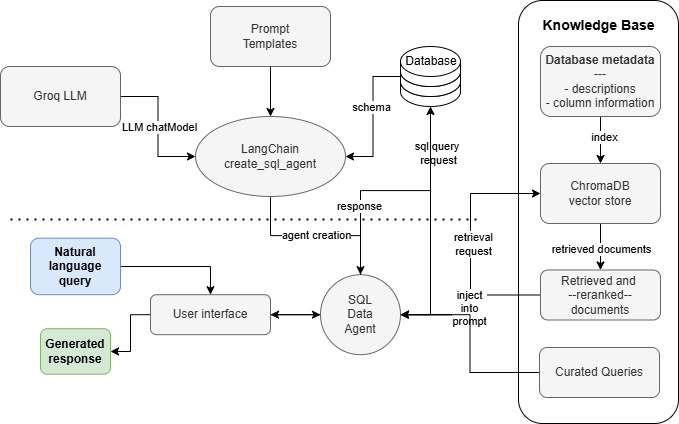

In [1]:
from IPython.display import Image
Image(filename='GenAI_db_poc.drawio.png')
# List out flow diagram of inputs to model outputs
# UI with chainlit

### Import libraries and setup paths and helper functions

In [2]:
import os
import sqlite3
import chromadb
from dotenv import load_dotenv
from typing_extensions import TypedDict
from langchain.utilities import SQLDatabase
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.prompts import ChatPromptTemplate, FewShotPromptTemplate, SystemMessagePromptTemplate, MessagesPlaceholder
from langchain_core.prompts import PromptTemplate
from langchain.agents.agent_types import AgentType
from langchain_groq import ChatGroq
from langchain.vectorstores.chroma import Chroma
from langchain_core.example_selectors import SemanticSimilarityExampleSelector

In [3]:
from langchain.text_splitter import RecursiveJsonSplitter # Importing text splitter from Langchain
from langchain.embeddings import HuggingFaceEmbeddings # Importing HuggingFace embeddings from Langchain
from langchain.schema import Document # Importing Document schema from Langchain
from langchain.vectorstores.chroma import Chroma
from langchain_community.document_loaders import JSONLoader, TextLoader

#### Load environment variables containing API keys for LLM and Embedding model providers

In [4]:
load_dotenv()

True

#### Constants and paths to database and metadata files

In [7]:
DB_PATH = "data/main2.db"
KB_PATHS = [
    "/home/richhiey/Desktop/code/genai/data/conventional_power_plants/datapackage.json",
    "/home/richhiey/Desktop/code/genai/data/national_generation_capacity/datapackage.json",
    "/home/richhiey/Desktop/code/genai/data/renewable_power_plants/datapackage.json",
    # "/home/richhiey/Desktop/code/genai/data/weather_data/datapackage.json",
    # "/home/richhiey/Desktop/code/genai/data/wind_solar_time_series/datapackage.json"
]
ALL_DATASETS_PATH = "pdl121024.json"

In [ ]:
# Define a list of example queries and their corresponding SQL queries
curated_queries = [
    {
        "input": "List all conventional power plants in Neidersachsen.",
        "query": "SELECT * FROM conventional_power_plants_DE where state=Neidersachsen;"
    },
    {
        "input": "List capacity of all conventional power plants in Germany group by the technology used",
        "query": "SELECT SUM(capacity) FROM conventional_power_plants_DE WHERE country=Germany GROUP BY technology;",
    },
    {
        "input": "List top 3 ",
        "query": "SELECT * FROM Movies WHERE Year = 2020;",
    },
]

#### Helper functions

In [71]:
# DB_METADATA_FILTERS = ["name", "title", "description", "longDescription", "keywords", "temporalScope", "geographicalScope", "schema"]
def filter_metadata(metadata_path):
    metadata = read_json(metadata_path)
    filtered_metadata = {}
    filtered_metadata["name"] = metadata["name"]
    filtered_metadata["title"] = metadata["title"]
    filtered_metadata["description"] = metadata["description"]
    filtered_metadata["longDescription"] = metadata["longDescription"]
    filtered_metadata["keywords"] = metadata["keywords"]
    if metadata.get("geographicalScope"):
        filtered_metadata["geographicalScope"] = metadata["geographicalScope"]
    if metadata.get("temporalScope"):
        filtered_metadata["temporalScope"] = metadata["temporalScope"]
    resources =  metadata["resources"]
    filtered_resources = []
    for resource in resources:
        if resource.get("schema") and resource.get("profile") == "tabular-data-resource":
            filtered_resource = {}
            filtered_resource["schema"] = resource["schema"]
            if filtered_resource.get("title"):
                filtered_resource["title"] = resource["title"]
            if filtered_resource.get("name"):
                filtered_resource["name"] = resource["name"]
            filtered_resources.append(filtered_resource)
    filtered_metadata["resources"] = filtered_resources
    return filtered_metadata

In [72]:
filter_metadata("/home/richhiey/Desktop/code/genai/data/conventional_power_plants/datapackage.json")

{'name': 'opsd-conventional_power_plants',
 'title': 'Conventional power plants',
 'description': 'List of conventional power plants in Germany and European countries',
 'longDescription': 'This datapackage contains data on conventional power plants for Germany as well as other selected European countries. The data includes individual power plants with their technical characteristics. These include installed capacity, main energy source, type of technology, CHP capability, and geographical information. The geographical scope is primarily on Germany and its neighboring countries. The datapackage currently covers Germany, Austria, Belgium, Switzerland, Czech Republic, Denmark, Spain, Finland, France, Italy, the Netherlands, Norway, Poland, Sweden, Slovakia, Slovenia, and United Kingdom. Due to varying data quality of publicly available data, not all information can be provided for each country. Sources for European countries comprise detailed power plants lists from national institutions

In [76]:
def create_sql_agent(
    llm: BaseLanguageModel,
    tools: Sequence[BaseTool],
    prompt: ChatPromptTemplate,
    message_formatter: MessageFormatter = format_to_tool_messages,
) -> Runnable:
    """Create an agent that uses tools.

    Args:
        llm: LLM to use as the agent.
        tools: Tools this agent has access to.
        prompt: The prompt to use. See Prompt section below for more on the expected
            input variables.
        message_formatter: Formatter function to convert (AgentAction, tool output)
            tuples into FunctionMessages.

    Returns:
        A Runnable sequence representing an agent. It takes as input all the same input
        variables as the prompt passed in does. It returns as output either an
        AgentAction or AgentFinish.
        missing_vars = {"agent_scratchpad"}.difference(
        prompt.input_variables + list(prompt.partial_variables)
    )
    """
    if missing_vars:
        raise ValueError(f"Prompt missing required variables: {missing_vars}")
    if not hasattr(llm, "bind_tools"):
        raise ValueError(
            "This function requires a .bind_tools method be implemented on the LLM.",
        )
    llm_with_tools = llm.bind_tools(tools)
    agent = (
        RunnablePassthrough.assign(
            agent_scratchpad=lambda x: message_formatter(x["intermediate_steps"]))
        | prompt| llm_with_tools | ToolsAgentOutputParser()
    )
    return agent

NameError: name 'format_to_tool_messages' is not defined

### Load SQL database

In [9]:
db = SQLDatabase.from_uri(f"sqlite:///{DB_PATH}")

In [10]:
# Connect to the SQLite database
connection = sqlite3.connect(DB_PATH)
cursor = connection.cursor()
# Query to get all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Extract table names from the result
table_names = [table[0] for table in tables]
table_names_str = f"Tables: {table_names}"
print("Tables:", table_names)

# Function to get column names for a given table
def get_column_names(table_name):
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    column_names = [column[1] for column in columns]
    return column_names

column_info_str = ""
# Get column names for each table
for table in table_names:
    columns = get_column_names(table)
    column_info_str += f"Columns in {table}: {columns}"

Tables: ['conventional_power_plants_DE', 'conventional_power_plants_EU', 'national_generation_capacity_stacked', 'renewable_power_plants_UK', 'renewable_power_plants_CH', 'renewable_power_plants_CZ', 'renewable_power_plants_PL', 'res_plants_separated_DE_outvalidated_plants', 'res_plants_separated_FR_outvalidated_plants', 'renewable_power_plants_DK', 'renewable_power_plants_DE', 'renewable_power_plants_SE', 'renewable_power_plants_FR', 'validation_marker', 'renewable_power_plants_EU', 'renewable_capacity_timeseries']


In [11]:
# check that the database has been instantiated correctly
print(db.get_usable_table_names())
print(cursor.execute('SELECT * FROM conventional_power_plants_DE'))
# Get column names
column_names = [description[0] for description in cursor.description]
print(column_names)
print(cursor.execute('SELECT * FROM conventional_power_plants_DE limit 1').fetchall())

['conventional_power_plants_DE', 'conventional_power_plants_EU', 'national_generation_capacity_stacked', 'renewable_capacity_timeseries', 'renewable_power_plants_CH', 'renewable_power_plants_CZ', 'renewable_power_plants_DE', 'renewable_power_plants_DK', 'renewable_power_plants_EU', 'renewable_power_plants_FR', 'renewable_power_plants_PL', 'renewable_power_plants_SE', 'renewable_power_plants_UK', 'res_plants_separated_DE_outvalidated_plants', 'res_plants_separated_FR_outvalidated_plants', 'validation_marker']
['id', 'name_bnetza', 'block_bnetza', 'name_uba', 'company', 'street', 'postcode', 'city', 'state', 'country', 'capacity_net_bnetza', 'capacity_gross_uba', 'energy_source', 'technology', 'chp', 'chp_capacity_uba', 'commissioned', 'commissioned_original', 'retrofit', 'shutdown', 'status', 'type', 'lat', 'lon', 'eic_code_plant', 'eic_code_block', 'efficiency_data', 'efficiency_source', 'efficiency_estimate', 'energy_source_level_1', 'energy_source_level_2', 'energy_source_level_3', '

In [12]:
def write_prompt(query_prompt_template: ChatPromptTemplate, state: dict):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "table_names_str": table_names_str,
            "column_info_str": column_info_str,
            "knowledge_base": state["knowledge_base"]
        }
    )
    return prompt

def read_file(filename):
    with open(filename, "r") as f:
        contents = f.read()
    return contents

def read_json(filename):
    with open(filename, "r") as f:
        json_data = json.load(f)
    return json_data

### Index knowledge base text into ChromaDB

In [13]:
embedding_model = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2') # Look into best embedding models

/tmp/ipykernel_272685/4216347365.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
/home/richhiey/Desktop/code/opsd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
import json
import itertools
from langchain_text_splitters import RecursiveJsonSplitter
from langchain.docstore.document import Document
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank

documents = [read_json(kb_path) for kb_path in KB_PATHS]
json_splitter = RecursiveJsonSplitter(max_chunk_size=500)
split_documents = [json_splitter.split_json(doc) for doc in documents]
splits = list(itertools.chain(*split_documents))
splits = [Document(page_content=str(doc)) for doc in splits]
chroma_vector_database = Chroma.from_documents(documents=splits, embedding=embedding_model)

In [69]:
query = "List the amount of capacity installed for each type of technology in Germany from conventional_power_plants_DE?"
retriever = chroma_vector_database.as_retriever(search_kwargs={"k":10})
retrieved_results = retriever.get_relevant_documents(query)
retrieved_results = [result.page_content for result in retrieved_results]
retrieved_results_str = '\n'.join(map(str, retrieved_results))

print(len(retrieved_results))
print(retrieved_results_str)

10
List capacity of all conventional power plants in Germany group by the technology used
{'name': 'opsd-conventional_power_plants', 'title': 'Conventional power plants', 'description': 'List of conventional power plants in Germany and European countries', 'longDescription': 'This datapackage contains data on conventional power plants for Germany as well as other selected European countries. The data includes individual power plants with their technical characteristics. These include installed capacity, main energy source, type of technology, CHP capability, and geographical information. The geographical scope is primarily on Germany and its neighboring countries. The datapackage currently covers Germany, Austria, Belgium, Switzerland, Czech Republic, Denmark, Spain, Finland, France, Italy, the Netherlands, Norway, Poland, Sweden, Slovakia, Slovenia, and United Kingdom. Due to varying data quality of publicly available data, not all information can be provided for each country. Sources

In [16]:
# compressor = RankLLMRerank(top_n=3, model="zephyr")
# compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
# compressed_docs = compression_retriever.invoke(query)

### Setup prompt template

In [17]:
SYSTEM_PROMPT_MESSAGE = """
You are a SQL Data analyst.
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.
Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Ensure that the generated response contains only a valid {dialect} query without any headers. Return only a single SQL query for each question.
Always enclose the generated SQL query in a markdown code block, start with ```sql and ending with ```.
If a directly relevant column is not found within the tables, stop the chain-of-thought and return an output saying "I cannot answer this" and state the reason for the same.
---
Here is some information about the database
---
Context
---
{knowledge_base}
---
Only use the following tables:
The tables in the given database are:
{table_names_str}
The columns for the tables in the database are:
{column_info_str}
{table_info}
"""

#### Figure out how to use a few-shot prompt template with Langchain agent

In [18]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    curated_queries,
    HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2'),
    Chroma,
    k=3,
    input_keys=["input"],
)
few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=PromptTemplate.from_template(
        "User input: {input}\nSQL query: {query}"
    ),
    input_variables=["input"],
    prefix=SYSTEM_PROMPT_MESSAGE,
    suffix="",
)
full_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate(prompt=few_shot_prompt),
    ("human", "{input}"),
    MessagesPlaceholder("agent_scratchpad"),
    MessagesPlaceholder("tools"),
    MessagesPlaceholder("tool_names")
])

### Instantiate the LLM to create a sql agent

#### Free HF LLM model: zephyr-7b-beta

In [19]:
endpoint = HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    max_new_tokens=512,
    do_sample=True,
    repetition_penalty=1.03,
)
llm = ChatHuggingFace(llm=endpoint)

#### Groq Mixtral-7b model

In [63]:
GROQ_MODEL_NAME = "llama3-8b-8192"
# GROQ_MODEL_NAME = "llama3-8b-8192"
gpt = ChatGroq(temperature=0, api_key=GROQ_API_KEY, model_name=GROQ_MODEL_NAME)

#### Setup agent executor

In [64]:
agent_executor = create_sql_agent(
    llm=gpt,
    toolkit=SQLDatabaseToolkit(db=db, llm=llm),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

### Run the agent to answer natural language queries

In [65]:
def run_agent_with_knowledge_base(agent_executor, retriever, question):
    query_prompt_template = ChatPromptTemplate.from_messages([("system", SYSTEM_PROMPT_MESSAGE)])
    retriever = chroma_vector_database.as_retriever(search_kwargs={"k":5})
    retrieved_results = retriever.get_relevant_documents(question)
    retrieved_results = [result.page_content for result in retrieved_results]
    retrieved_results_str = '\n'.join(map(str, retrieved_results))
    context = write_prompt(query_prompt_template, {"knowledge_base": retrieved_results_str})
    agent_executor.run(input=question, context=context)

#### Double check answers by executing human-made SQL queries

In [26]:
query = "SELECT technology, SUM(capacity_net_bnetza) AS total_capacity FROM conventional_power_plants_DE GROUP BY technology LIMIT 10"
results = cursor.execute(query).fetchall()
print(results)
query = "SELECT SUM(electrical_capacity) FROM (SELECT electrical_capacity FROM renewable_power_plants_DE UNION ALL SELECT electrical_capacity FROM renewable_power_plants_FR UNION ALL SELECT electrical_capacity FROM renewable_power_plants_PL)"
results = cursor.execute(query).fetchall()
print(results)
query = "SELECT energy_source, SUM(capacity_net_bnetza) AS total_net_capacity, SUM(capacity_gross_uba) AS total_gross_capacity FROM conventional_power_plants_DE GROUP BY energy_source ORDER BY total_net_capacity, total_gross_capacity DESC"
results = cursor.execute(query).fetchall()
print(results)

[('Combined cycle', 18949.409), ('Combustion Engine', 91.07), ('Gas turbine', 4065.62), ('Pumped storage', 9812.2), ('RES', 1324.5), ('Reservoir', 124.0), ('Run-of-river', 2608.45), ('Steam turbine', 83020.7159), ('Storage technologies', 184.5)]
[(145841.4035462919,)]
[('Mixed fossil fuels', 19.3, None), ('Other fossil fuels', 75.4, None), ('Biomass and biogas', 904.3434, 147.0), ('Waste', 1630.75, 75.71447), ('Other fuels', 2753.0, 2123.07948), ('Oil', 4311.7, 2656.86463), ('Nuclear', 12075.0, 8539.0), ('Hydro', 13869.15, 7056.53), ('Lignite', 22878.02, 20412.6174), ('Natural gas', 28536.0315, 18051.1863), ('Hard coal', 33127.77, 21943.80772)]


#### List the amount of capacity installed for each type of technology in Germany
Correct SQL statement
```sql
SELECT technology, SUM(capacity_net_bnetza) AS total_capacity 
FROM conventional_power_plants_DE
GROUP BY technology
```
```
[('Combined cycle', 18949.409), ('Combustion Engine', 91.07), ('Gas turbine', 4065.62), ('Pumped storage', 9812.2), ('RES', 1324.5), ('Reservoir', 124.0), ('Run-of-river', 2608.45), ('Steam turbine', 83020.7159), ('Storage technologies', 184.5)]
```

In [27]:
question = "List the amount of capacity installed for each type of technology in Germany from conventional_power_plants_DE?"
run_agent_with_knowledge_base(agent_executor, retriever, question)

/tmp/ipykernel_272685/1716257661.py:8: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  agent_executor.run(input=question, context=context)




> Entering new SQL Agent Executor chain...
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.
Action: sql_db_list_tables
I see that the table `conventional_power_plants_DE` is in the list of tables. I should query the schema of this table to see what columns are available.enewable_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker

Action: sql_db_schema
Action Input: conventional_power_plants_DE
CREATE TABLE "conventional_power_plants_DE" (
	id TEXT, 
	name_bnetza TEXT, 
	block_bnetza TEXT, 
	name_uba TEXT, 
	company TEXT, 
	street TEXT, 
	postcode TEXT, 
	city TEXT, 
	state TEXT, 
	country TEXT, 
	capacity_net_b

#### List the the total capacity of all renewable energy sources installed within Germany, France and Poland?
Note: We have a unique table named renewable_power_sources_DE for Germany but do not have a similar table for Spain
```sql
SELECT SUM(electrical_capacity) FROM (
    SELECT electrical_capacity FROM renewable_power_plants_DE 
    UNION ALL
    SELECT electrical_capacity FROM renewable_power_plants_FR
    UNION ALL
    SELECT electrical_capacity FROM renewable_power_plants_PL
)
```
```
[(145841.4035462919,)]
```

In [28]:
question = "List the the total capacity of all renewable energy sources installed within Germany, France and Poland?"
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.
Action: sql_db_list_tables
Thought: Based on the table names, I think I should focus on the tables related to renewable power plants, specifically those for Germany, France, and Poland.le_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker

Action: sql_db_schema
Action Input: renewable_power_plants_DE, renewable_power_plants_FR, renewable_power_plants_PL
CREATE TABLE "renewable_power_plants_DE" (
	electrical_capacity FLOAT, 
	energy_source_level_1 TEXT, 
	energy_source_level_2 TEXT, 
	energy_source_level_3 TEXT, 
	technol

#### List down the number of power plants by country and state.

In [29]:
question = "List down the number of power plants by country and state."
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.
Action: sql_db_list_tables
From the list of tables, I think the most relevant tables for this question are `conventional_power_plants_EU` and `renewable_power_plants_EU`, as they seem to contain information about power plants in Europe.wable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker

Action: sql_db_schema
Action Input: conventional_power_plants_EU, renewable_power_plants_EU
CREATE TABLE "conventional_power_plants_EU" (
	name TEXT, 
	company TEXT, 
	street TEXT, 
	postcode TEXT, 
	city TEXT, 
	country TEXT, 
	capacity REAL, 
	energy_source TEXT, 
	technology TEXT, 


#### List down the total installed capacity (net and gross) for each energy source in Germany.
```sql
SELECT energy_source, 
       SUM(capacity_net_bnetza) AS total_net_capacity, 
       SUM(capacity_gross_uba) AS total_gross_capacity
FROM opsd_conventional_power_plants_DE
GROUP BY energy_source
ORDER BY total_net_capacity, total_gross_capacity
```
```
[('Biomass and biogas', 904.3434, 147.0), ('Hard coal', 33127.77, 21943.80772), ('Hydro', 13869.15, 7056.53), ('Lignite', 22878.02, 20412.6174), ('Mixed fossil fuels', 19.3, None), ('Natural gas', 28536.0315, 18051.1863), ('Nuclear', 12075.0, 8539.0), ('Oil', 4311.7, 2656.86463), ('Other fossil fuels', 75.4, None), ('Other fuels', 2753.0, 2123.07948), ('Waste', 1630.75, 75.71447)]
```

In [38]:
question = "List down the total installed capacity (net and gross) for each energy source in Germany."
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Question: List down the total installed capacity (net and gross) for each energy source in Germany.
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.

Action: sql_db_list_tables
Question: List down the total installed capacity (net and gross) for each energy source in Germany.on_capacity_stacked, renewable_capacity_timeseries, renewable_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.

Action: sql_db_list_tables
Question: List down

#### Historical analysis of trends
Q: Track the number of plants commissioned by decade.

Note: Failed with llama-8b, gets this right with llama-70b

In [56]:
question = "Track the number of plants commissioned in the european union by decade."
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Let's start by listing the tables in the database:

Action: sql_db_list_tables
Question: Track the number of plants commissioned in the european union by decade.er_plants_EU, national_generation_capacity_stacked, renewable_capacity_timeseries, renewable_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.

Action: sql_db_schema
Action Input: conventional_power_plants_EU, renewable_power_plants_EU
CREATE TABLE "conventional_power_plants_EU" (
	name TEXT, 
	company TEXT, 
	street TEXT, 
	postcode TEXT, 
	city TEXT, 
	country

#### Find Countries with Above-Average Capacity

Q: Identify countries where the total installed capacity is below the overall average.

Failed with llama-8b, gets this right with llama-70b

In [47]:
question = "Identify countries where the total installed capacity is above the overall average."
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Let's start by listing the tables in the database:

Thought: I should list the tables in the database to see what I can query.
Action: sql_db_list_tables
Question: Identify countries where the total installed capacity is above the overall average.U, national_generation_capacity_stacked, renewable_capacity_timeseries, renewable_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.

Let's start by listing the tables in the database:

Action: sql_db_list_tables
Thought: I need to query the schema of the tables to see what colu

#### Cities densely populated with power plants

Q: Identify power plants located in cities where the number of plants exceeds the average per city.

Correct SQL statement:
```
SELECT city, COUNT(*) AS plant_count
FROM opsd_conventional_power_plants_DE
GROUP BY city
HAVING COUNT(*) > (
    SELECT AVG(city_plant_count)
    FROM (
        SELECT COUNT(*) AS city_plant_count
        FROM opsd_conventional_power_plants_DE
        GROUP BY city
    ) sub
);
```

In [66]:
question = "Identify power plants located in cities where the number of plants exceeds the average per city."
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Let's start by listing the tables in the database:

Action: sql_db_list_tables
Let's start by analyzing the tables listed. It seems that we have tables related to power plants, such as `conventional_power_plants_DE`, `renewable_power_plants_DE`, etc. We also have tables related to capacity and validation.e_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker

Action: sql_db_schema
It seems that the table "cities" does not exist in the database. Let's try to list all the tables again to see if we can find a table related to cities.

Action: sql_db_list_tables
Let's continue from where we left off.nventional_power_plants_DE, conventional_power_plants_EU, national_generation_capacity_stacked, renewable_capacity_tim

#### Identify Most Efficient Plants per Technology
Q: Find the plant with the highest efficiency for each technology

In [45]:
question = "Find the plant with the highest efficiency for each technology."
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Let's start by listing the tables in the database:

Action: sql_db_list_tables
Let's start by analyzing the question and identifying the relevant tables and columns.tional_generation_capacity_stacked, renewable_capacity_timeseries, renewable_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker

Action: sql_db_schema
Action Input: conventional_power_plants_DE, conventional_power_plants_EU, renewable_power_plants_DE, renewable_power_plants_EU
CREATE TABLE "conventional_power_plants_DE" (
	id TEXT, 
	name_bnetza TEXT, 
	block_bnetza TEXT, 
	name_uba TEXT, 
	company TEXT, 
	street TEXT, 
	postcode TEXT, 
	city TEXT, 
	state TEXT, 
	country TEXT, 
	capacity_net_bn

#### Negative test!

Q. Caluclate the 30-day moving average of temperature and return the result at the monthly level

The catch here is that we have not included tables with temperature data in the database.
Hence this answer cannot be determined.

In [43]:
question = "Caluclate the 30-day moving average of temperature and return the result at the monthly level"
run_agent_with_knowledge_base(agent_executor, retriever, question)



> Entering new SQL Agent Executor chain...
Question: Calculate the 30-day moving average of temperature and return the result at the monthly level
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.

Action: sql_db_list_tables
Question: Calculate the 30-day moving average of temperature and return the result at the monthly levelapacity_stacked, renewable_capacity_timeseries, renewable_power_plants_CH, renewable_power_plants_CZ, renewable_power_plants_DE, renewable_power_plants_DK, renewable_power_plants_EU, renewable_power_plants_FR, renewable_power_plants_PL, renewable_power_plants_SE, renewable_power_plants_UK, res_plants_separated_DE_outvalidated_plants, res_plants_separated_FR_outvalidated_plants, validation_marker
Thought: I should look at the tables in the database to see what I can query.  Then I should query the schema of the most relevant tables.

Action: sql_db_list_tables
Question: Calcu